# To Do: 
- add PCAN and Syowa to plots
- Check I2E voyage model output lines up with ruhis obs,
- Also I think the KCG obs can actually go from 2015-2019? Same with Swoya, so it might be worth getting that full data set too..
- Figure out what is going on with the KCG CCN - I feel like there is domething missing there?
- I've asked Ruhi if the CAMMPCAN CCN/CN is available - do you know? It would be good to include that campaign if we can! 


# Preamble

In [1]:
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
matplotlib.rcParams['pdf.fonttype'] = 42
from datetime import datetime
import scipy.special
import xarray as xr

In [2]:
obs_names = ['CAPRICORN1','CAPRICORN2','MARCUS','Ice2Equator','Cold Water Trial','PCAN','Kennaook-Cape Grim','Macquarie Island','Syowa'] 
vnames = ['cap16','cap18','aa1718','i2e16','cwt15','pcan','cgo1618','mqi1618','syw1618'] # need to add PCAN Syowa - update names
cols = ['steelblue','indianred','maroon','goldenrod','forestgreen','black']
run = ['Control','BL NPF','OM2 DMS','PMO','Rev3 DMS','Obs']

In [3]:
fig_dir = '/home/563/slf563/shared_code/access-eval'

# Organise Observations 

In [4]:
def read_obs(name):
    f_path = '/g/data/jk72/slf563/OBS/campaigns/cleaned_SO_campaign_data/'
    data = pd.read_csv(f_path+'aerosol - {} - daily means from hrly data.csv'.format(name),index_col=0)
    data.index = pd.DatetimeIndex(data.index)
    data.index = data.index.rename('time')

    # Make all CN names the same - will make dummy if does not exist 
    if 'cn_avg' not in data.keys():
        if 'cn10_avg' not in data.keys():
            data['cn10_avg'] = np.nan
    else: 
        data = data.rename(columns={'cn_avg':'cn10_avg'})

    # Make all CCN names the same - will make dummy if does not exist 
    if 'ccn_avg' not in data.keys():
        if 'ccn_0.5504_avg' in data.keys():
            data = data.rename(columns={'ccn_0.5504_avg':'ccn_avg'})
        elif 'ccn_0.5_avg' in data.keys():
            data = data.rename(columns={'ccn_0.5_avg':'ccn_avg'})
        elif 'ccn_0.55_avg' in data.keys():
            data = data.rename(columns={'ccn_0.55_avg':'ccn_avg'})
        elif 'ccn_0.55_avg' in data.keys():
            data = data.rename(columns={'ccn_0.55_avg':'ccn_avg'})
        elif 'ccn_n' in data.keys():
            data = data.rename(columns={'CCN_Count':'ccn_avg'}) # THIS IS FOR KCG - dont know if it should be count to n
        else:    
            data['ccn_avg'] = np.nan

    return data

# Organise model data

In [5]:
def read_model_data(run,voyage,field): 
    
    fdir = '/g/data/jk72/ll6859/access_aero_eval/output/'
    if os.path.exists(fdir+'{}_{}_track.nc'.format(voyage,run)): 
        data = xr.open_dataset(fdir+'{}_{}_track.nc'.format(voyage,run))
        
        data = data[[field,'lat','lon']].assign_coords(model=run)
        data = data.sortby('time')
        data
        if voyage == 'i2e16': # limit to south of 47.5
            data = data.where(data.lat<-47.5)
                
    else: print('no data')
    return(data)

In [6]:
 def organise_model_data(voyage,feild):
    fld1 = read_model_data('bx400',voyage,feild)
    fld2 = read_model_data('cg283',voyage,feild)
    fld3 = read_model_data('ch543',voyage,feild)
    fld4 = read_model_data('cq686',voyage,feild)
    fld5 = read_model_data('cq687',voyage,feild)
    if voyage == 'aa1819': 
        fld3['time'] = fld1['time']
    feild = xr.concat([fld1,fld2,fld3,fld4,fld5],dim='model')
    feild['model'] = run[:-1] 
    return feild

In [7]:
def combine_model_obs(obsname,field,sim='Control'):
    i = obs_names.index(obsname)
    modname = vnames[i]
    if field == 'N10': 
        obsf = 'cn10_avg'
    if field == 'CCN50': 
        obsf = 'ccn_avg'    
    N10 = organise_model_data(modname,field).squeeze()
    obs = read_obs(obsname)
    if sim != 'all': 
        N10 = N10.loc[{'model':sim}]
        N10 = N10.to_pandas()
        N10['Obs'] = obs[obsf]
        N10 = N10.dropna()
        
    else: 
        N10 = N10[field].T.to_pandas()
        if obsname not in ['Macquarie Island','Kennaook-Cape Grim','Syowa']: 
            obs = obs[[obsf,'lat','lon']]
            N10[['Obs','lat','lon']] = obs
        else: 
            obs = obs[obsf]
            N10['Obs'] = obs
        N10 = N10.dropna()
    
    return N10

# Plot Map 

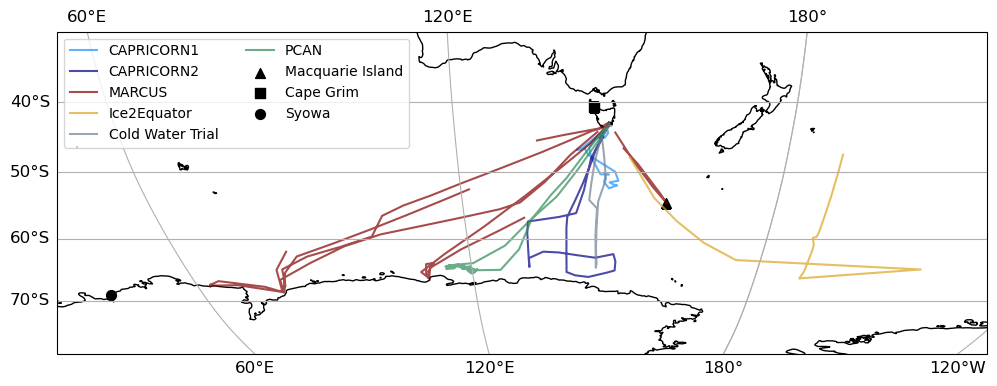

In [8]:
ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=140, globe=None))#PlateCarree(120))
ax.figure.set_size_inches(12,10)
ax.coastlines();
ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True);
ax.set_extent((55,210,-50,-30))

colors = ['dodgerblue','navy','maroon','goldenrod',
          'slategrey','seagreen']

for i,v in enumerate(obs_names[:-3]):
    data = read_obs(v)
    data['lon'] = data.lon % 360
    plt.plot(data['lon'], 
                data['lat'],
                transform=ccrs.PlateCarree(),
                color=colors[i],alpha=0.7,
                label=v)
    

plt.scatter(x=158.861, y=-54.6199, s=50, c='black', marker='^', 
            transform=ccrs.PlateCarree(), label='Macquarie Island')

plt.scatter(x=144.6833, y=-40.68333, s=50, c='black', marker='s', 
            transform=ccrs.PlateCarree(), label='Cape Grim')

plt.scatter(x=39.59, y=-69.0, s=50, c='black', marker='o', 
            transform=ccrs.PlateCarree(), label='Syowa')
    
plt.legend(ncol=2,loc='upper left')


plt.rcParams.update({'font.size': 12})
# plt.savefig(fig_dir+'/figures/field_observations.pdf',bbox_inches='tight')

# Plot station time series 
## CN first

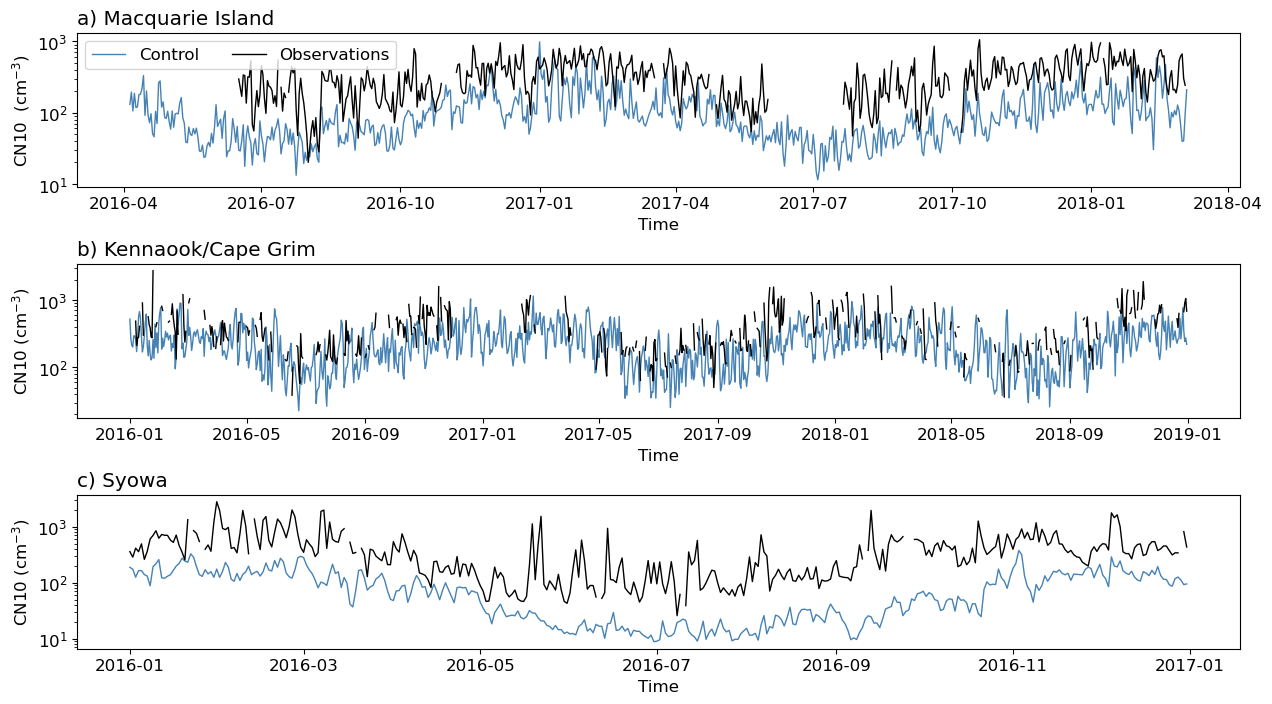

In [9]:
ax = plt.subplot(311,)
ax.figure.set_size_inches(15, 8)

f = organise_model_data('mqi1618','N10') 
obs = read_obs('Macquarie Island')

plt.plot(f.time, f['N10'][f.model=='Control'][0,:,0], color='steelblue', label='Control',linewidth=1,linestyle='-')

plt.plot(obs.index, obs['cn10_avg'], color='black', label='Observations',linewidth=1)
plt.xlabel('Time')
plt.ylabel('CN10  (cm$^{-3}$)')
plt.yscale('log')
plt.rcParams.update({'font.size': 12})
plt.title('a) Macquarie Island',loc='left')
plt.legend(loc='upper left',ncol=2)
#*********************************************************************************************************************
ax = plt.subplot(312,)
f = organise_model_data('cgo1618','N10') 
obs = read_obs('Kennaook-Cape Grim')
               
plt.plot(f.time, f['N10'][f.model=='Control'][0,:,0], color='steelblue', label='Control',linewidth=1,linestyle='-')

plt.plot(obs.loc['2016':'2018'].index, obs.loc['2016':'2018']['cn10_avg'], color='black', label='Observations',linewidth=1)
plt.xlabel('Time')
plt.ylabel('CN10 (cm$^{-3}$)')
plt.yscale('log')
plt.rcParams.update({'font.size': 12})
plt.title('b) Kennaook/Cape Grim',loc='left');

#*********************************************************************************************************************
ax = plt.subplot(313,)
f = organise_model_data('syw1618','N10') 
obs = read_obs('Syowa')
               
plt.plot(f.time, f['N10'][f.model=='Control'][0,:,0], color='steelblue', label='Control',linewidth=1,linestyle='-')

plt.plot(obs.loc['2016':'2018'].index, obs.loc['2016':'2018']['cn10_avg'], color='black', label='Observations',linewidth=1)
plt.xlabel('Time')
plt.ylabel('CN10 (cm$^{-3}$)')
plt.yscale('log')
plt.rcParams.update({'font.size': 12})
plt.title('c) Syowa',loc='left');


plt.subplots_adjust(hspace=0.5)


Quite a different performance from the model between KCG and MI - will be interesting to see Syowa. 
I know some people hate timeseries, but I think they are always good to just get a first idea of what the data looks like... kind of sets the scene. 

## CCN
Note no CCN for Syowa 

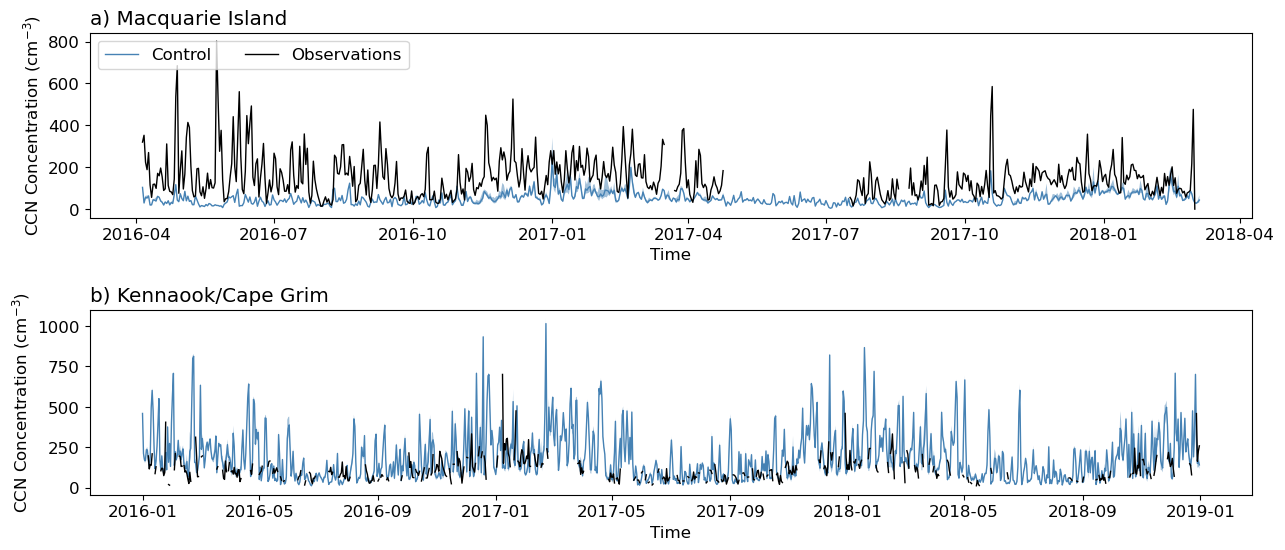

In [10]:
ax = plt.subplot(211,)
ax.figure.set_size_inches(15, 6)

f40 = organise_model_data('mqi1618','CCN40')
f50 = organise_model_data('mqi1618','CCN50') 
f60 = organise_model_data('mqi1618','CCN60')
obs = read_obs('Macquarie Island')
                          
plt.plot(f50.time, f50['CCN50'][f50.model=='Control'][0,:,0], color='steelblue', label='Control',linewidth=1,linestyle='-')
ax.fill_between(f40.time, f40['CCN40'][f40.model=='Control'][0,:,0], 
                f60['CCN60'][f60.model=='Control'][0,:,0], facecolor='steelblue',alpha=0.5)


plt.plot(obs.index, obs['ccn_avg'], color='black', label='Observations',linewidth=1)
plt.xlabel('Time')
plt.ylabel('CCN Concentration (cm$^{-3}$)')
#plt.yscale('log')
plt.rcParams.update({'font.size': 12})
plt.title('a) Macquarie Island',loc='left')
plt.legend(loc='upper left',ncol=2)
#*********************************************************************************************************************
ax = plt.subplot(212,)

f40 = organise_model_data('cgo1618','CCN40')
f50 = organise_model_data('cgo1618','CCN50') 
f60 = organise_model_data('cgo1618','CCN60')
obs = read_obs('Kennaook-Cape Grim')

                          
plt.plot(f50.time, f50['CCN50'][f50.model=='Control'][0,:,0], color='steelblue', label='Control',linewidth=1,linestyle='-')
ax.fill_between(f40.time, f40['CCN40'][f40.model=='Control'][0,:,0], 
                f60['CCN60'][f60.model=='Control'][0,:,0], facecolor='steelblue',alpha=0.5)

plt.plot(obs.loc['2016':'2018'].index, obs.loc['2016':'2018']['ccn_avg'], color='black', label='Observations',linewidth=1)
plt.xlabel('Time')
plt.ylabel('CCN Concentration (cm$^{-3}$)')
#plt.yscale('log')
plt.rcParams.update({'font.size': 12})
plt.title('b) Kennaook/Cape Grim',loc='left');

plt.subplots_adjust(hspace=0.5)

The CCN figures show in the solid line the CCN50 size, with the shaded area representing the CCN40 (bottom) and CCN60 (top) concentrations, as a measure of uncertainty... The shaded aread is very hard to see so that gives us confidence that CCN50 is ok. 

I think there is an issue with the KCG CCNs - have followed up with Ruhi

# Plot voyage data on map

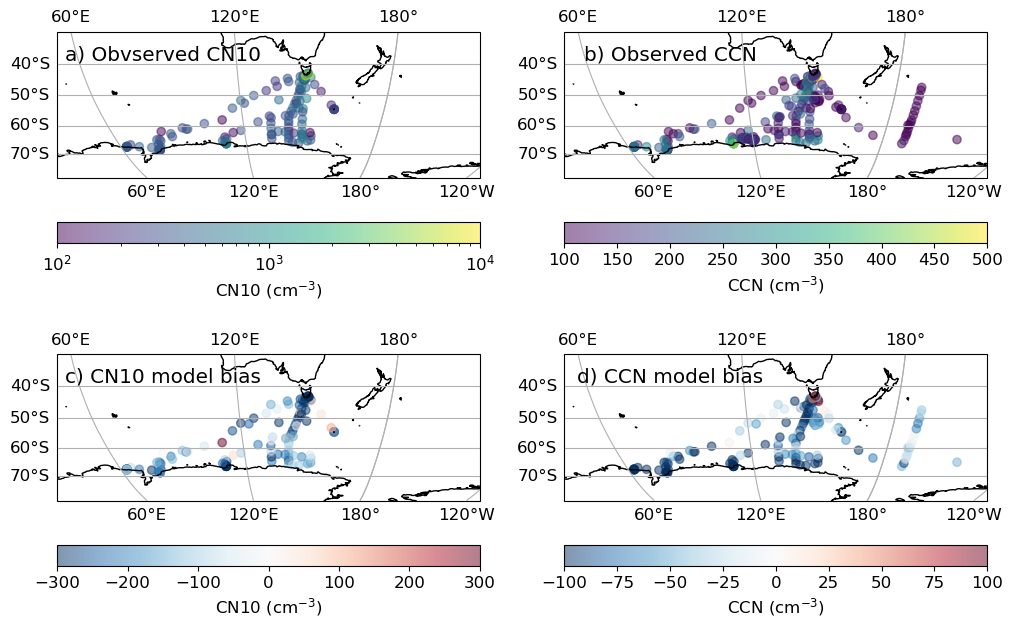

In [11]:
ax = plt.subplot(221, projection=ccrs.Robinson(central_longitude=140, globe=None))#PlateCarree(120))
ax.figure.set_size_inches(12,8)
ax.coastlines();
ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True);
ax.set_extent((55,210,-50,-30))

for i,v in enumerate(obs_names[:-3]):
    data = read_obs(v)
    data['lon'] = data.lon % 360
    plt.scatter(y=data['lat'], 
                x=data['lon'], 
                c=data['cn10_avg'], cmap='viridis', alpha=0.5,
                norm=matplotlib.colors.LogNorm(vmin=100,vmax=10000), 
                transform=ccrs.PlateCarree())
plt.colorbar(label='CN10 (cm$^{-3}$)', orientation='horizontal')
plt.title('a) Obvserved CN10',x=0.25,y=0.75)  

#************************************************************************
ax = plt.subplot(222, projection=ccrs.Robinson(central_longitude=140, globe=None))#PlateCarree(120))
ax.coastlines();
ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True);
ax.set_extent((55,210,-50,-30))

for i,v in enumerate(obs_names[:-3]):
    data = read_obs(v)
    data['lon'] = data.lon % 360
    plt.scatter(y=data['lat'], 
                x=data['lon'], 
                c=data['ccn_avg'], cmap='viridis', 
                #norm=matplotlib.colors.LogNorm(vmin=100,vmax=1000), 
                vmin=100,vmax=500,alpha=0.5,
                transform=ccrs.PlateCarree())
plt.colorbar(label='CCN (cm$^{-3}$)', orientation='horizontal',)
plt.title('b) Observed CCN',x=0.25,y=0.75)  

#************************************************************************
ax = plt.subplot(223, projection=ccrs.Robinson(central_longitude=140, globe=None))#PlateCarree(120))
ax.coastlines();
ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True);
ax.set_extent((55,210,-50,-30))

for i,v in enumerate(obs_names[:-4]):
    data = combine_model_obs(v,'N10')
    data['lon'] = data.lon % 360
    plt.scatter(y=data['lat'], 
                x=data['lon'], 
                c=data['N10']-data['Obs'], cmap='RdBu_r', 
                #norm=matplotlib.colors.LogNorm(vmin=100,vmax=1000), 
                vmin=-300,vmax=300,alpha=0.5,
                transform=ccrs.PlateCarree())
plt.colorbar(label='CN10 (cm$^{-3}$)', orientation='horizontal',)
plt.title('c) CN10 model bias',x=0.25,y=0.75)  

#************************************************************************
ax = plt.subplot(224, projection=ccrs.Robinson(central_longitude=140, globe=None))#PlateCarree(120))
ax.coastlines();
ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True);
ax.set_extent((55,210,-50,-30))

for i,v in enumerate(obs_names[:-4]):
    data = combine_model_obs(v,'CCN50')
    data['lon'] = data.lon % 360
    plt.scatter(y=data['lat'], 
                x=data['lon'], 
                c=data['CCN50']-data['Obs'], cmap='RdBu_r', 
                #norm=matplotlib.colors.LogNorm(vmin=100,vmax=1000), 
                vmin=-100,vmax=100,alpha=0.5,
                transform=ccrs.PlateCarree())
plt.colorbar(label='CCN (cm$^{-3}$)', orientation='horizontal',)
plt.title('d) CCN model bias',x=0.25,y=0.75)  

plt.rcParams.update({'font.size': 12})
plt.subplots_adjust(hspace=0.1)


Need to possibly re-run I2E with ruhis data - seems to have more obs available? 

This is just the absolute bias, I think that is ok, we can report the % in a table later..  

These maybe an appendix fig? not sure.. I think, like the time series, they just give the reader (and authors) and opportunity to eye ball the data a bit to get to know it. 

It is clear from this that there are also a couple of 'hot spots' - eg. at Casey and to a lesser degree along the antarctic shoreline, and near tassy.. 

# Plot seasonal stats for stations

## CN10 

In [12]:
def plot_station_monthly(data,field):

    if field == 'N10': 
        obsf = 'cn10_avg'
    if field == 'CCN50': 
        obsf = 'ccn_avg'  

    data = data.to_xarray()
    data_med = data.groupby('time.month').median()
    data_25 = data.groupby('time.month').quantile(0.25)
    data_75 = data.groupby('time.month').quantile(0.75)
    
    for i,r in enumerate(run):
        ax.fill_between(data_med.month, data_25[r].values, data_75[r].values, facecolor=cols[i],alpha=0.1)
        plt.plot(data_med.month, data_med[r].values, color=cols[i], label=r,linewidth=1)
    
        ax.fill_between([12.75+(i*0.05),13.25+(i*0.05)], data[r].quantile(0.25), data[r].quantile(0.75), 
                        facecolor=cols[i],alpha=0.1)
        plt.plot([12.75+(i*0.05),13.25+(i*0.05)],[data[r].median(),data[r].median()],color=cols[i])
    
    plt.xlabel('Month')
    if field == 'N10': 
        plt.ylabel('CN10 (cm$^{-3}$)')
        plt.yscale('log')
    elif field == 'CCN50':
        plt.ylabel('CCN (cm$^{-3}$)')
    elif field == 'CCN/CN10':
        plt.ylabel('Ratio (cm$^{-3}$)')
    
    plt.rcParams.update({'font.size': 12})
    #plt.legend(ncols=3,loc='upper left')
    plt.text(x = 0.89, y = 0.02, s = 'Annual',transform=ax.transAxes)
    plt.axvline(12.25,color='black',linewidth=0.5)

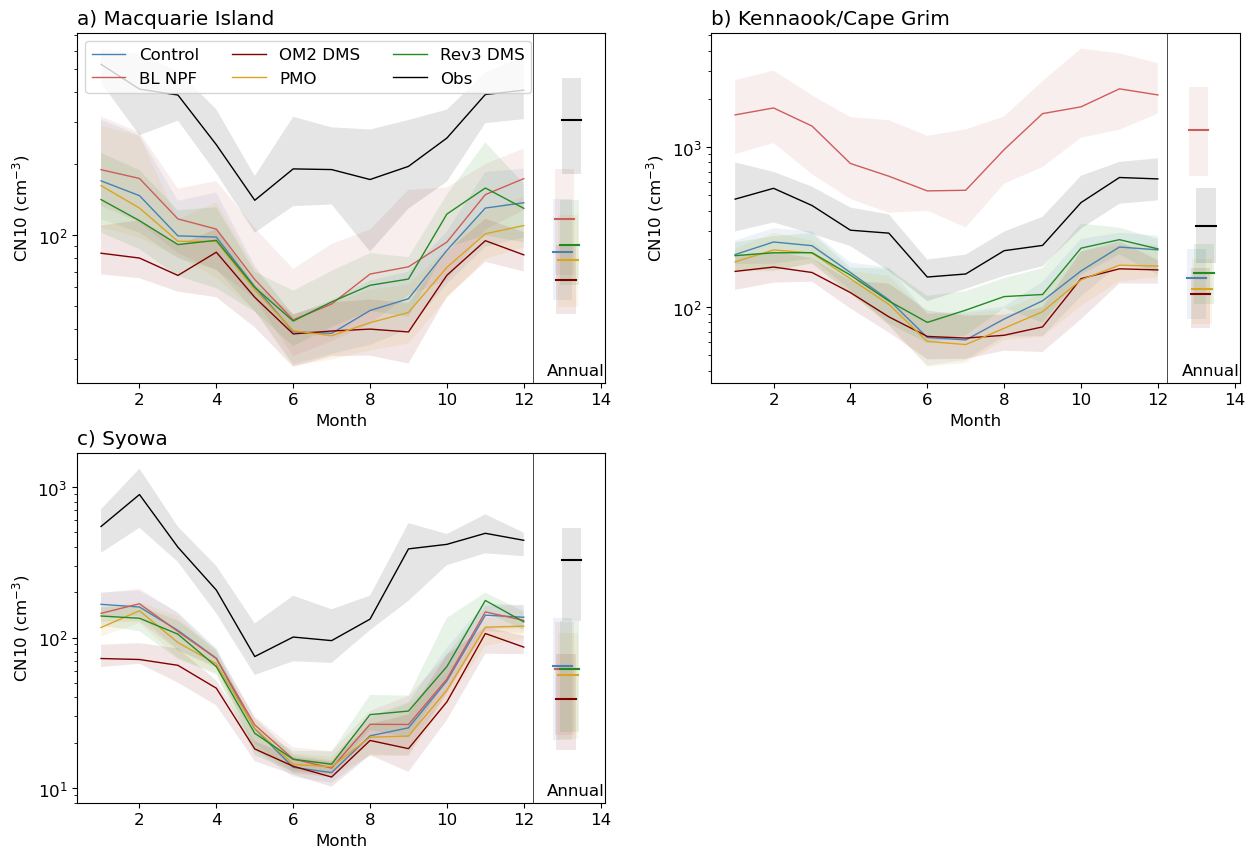

In [13]:
ax = plt.subplot(221,)
ax.figure.set_size_inches(15, 10)
data = combine_model_obs('Macquarie Island','N10',sim='all')
plot_station_monthly(data,'N10')
plt.title('a) Macquarie Island',loc='left');
plt.legend(ncols=3,loc='upper left')

#*********************************************************************************************************************

ax = plt.subplot(222,)
data = combine_model_obs('Kennaook-Cape Grim','N10',sim='all')
plot_station_monthly(data,'N10')
plt.title('b) Kennaook/Cape Grim',loc='left');


#*********************************************************************************************************************
# Swoya 
ax = plt.subplot(223,)
data = combine_model_obs('Syowa','N10',sim='all')
plot_station_monthly(data,'N10')
plt.title('c) Syowa',loc='left');


- Clearly there are very different regimes for the northern lats (KCG) compared to MI - will be interesting to see how Syowa performs.
- For MI (remebering only basline periods) turning on NPF marginally improves the model..but it is clear that there is a large missing source of (likely small) aerosol here.. Could it be because of the location of the station, where it perhaps getting alot more sea spray (though these might be larger particles)?, or could there be more biogenics here than we think? 
- for KCG, turning on NPF results in a large overestimation by the model? Could it be that there is alot of biological activity here? not sure.. need to check DMS files.The REV3 DMS does improve it a little bit... 

### Some stats: 

In [14]:
data = combine_model_obs('Macquarie Island','N10',sim='all')
data = data.to_xarray()
diffabs = data[run[:-1]] - data['Obs']
diffrel = 100*(data[run[:-1]]- data['Obs'])/data['Obs']
diffabs = diffabs.groupby('time.season').median()
diffrel = diffrel.groupby('time.season').median()

print('absolute diff Macquarie Island')
print(diffabs)
print(' ')
print('relative diff Macquarie Island')
print(diffrel)

absolute diff Macquarie Island
<xarray.Dataset>
Dimensions:   (season: 4)
Coordinates:
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    Control   (season) float64 -279.6 -138.1 -143.7 -188.5
    BL NPF    (season) float64 -240.9 -112.9 -133.9 -156.6
    OM2 DMS   (season) float64 -362.2 -139.1 -164.7 -206.8
    PMO       (season) float64 -300.7 -138.1 -142.8 -197.4
    Rev3 DMS  (season) float64 -303.4 -126.9 -143.4 -170.4
 
relative diff Macquarie Island
<xarray.Dataset>
Dimensions:   (season: 4)
Coordinates:
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    Control   (season) float64 -64.05 -76.31 -61.8 -68.6
    BL NPF    (season) float64 -58.14 -65.55 -57.81 -61.05
    OM2 DMS   (season) float64 -80.45 -78.02 -72.58 -76.67
    PMO       (season) float64 -68.24 -77.74 -63.98 -73.72
    Rev3 DMS  (season) float64 -70.02 -67.0 -63.05 -62.09


In [15]:
data = combine_model_obs('Kennaook-Cape Grim','N10',sim='all')
data = data.to_xarray()
diffabs = data[run[:-1]] - data['Obs']
diffrel = 100*(data[run[:-1]]- data['Obs'])/data['Obs']
diffabs = diffabs.groupby('time.season').median()
diffrel = diffrel.groupby('time.season').median()

print('absolute diff Kennaook-Cape Grim')
print(diffabs)
print(' ')
print('relative diff Kennaook-Cape Grim')
print(diffrel)

absolute diff Kennaook-Cape Grim
<xarray.Dataset>
Dimensions:   (season: 4)
Coordinates:
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    Control   (season) float64 -306.5 -103.1 -161.0 -255.5
    BL NPF    (season) float64 1.28e+03 575.2 479.8 1.298e+03
    OM2 DMS   (season) float64 -359.1 -108.4 -207.5 -292.5
    PMO       (season) float64 -346.8 -106.8 -170.6 -283.0
    Rev3 DMS  (season) float64 -323.4 -75.18 -160.0 -206.2
 
relative diff Kennaook-Cape Grim
<xarray.Dataset>
Dimensions:   (season: 4)
Coordinates:
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    Control   (season) float64 -59.68 -59.36 -51.32 -63.11
    BL NPF    (season) float64 259.8 323.0 200.7 312.1
    OM2 DMS   (season) float64 -69.17 -62.87 -64.28 -71.41
    PMO       (season) float64 -65.5 -61.04 -54.12 -70.22
    Rev3 DMS  (season) float64 -61.16 -44.02 -52.99 -57.89


In [16]:
data = combine_model_obs('Syowa','N10',sim='all')
data = data.to_xarray()
diffabs = data[run[:-1]] - data['Obs']
diffrel = 100*(data[run[:-1]]- data['Obs'])/data['Obs']
diffabs = diffabs.groupby('time.season').median()
diffrel = diffrel.groupby('time.season').median()

print('absolute diff Syowa')
print(diffabs)
print(' ')
print('relative diff Syowa')
print(diffrel)

absolute diff Syowa
<xarray.Dataset>
Dimensions:   (season: 4)
Coordinates:
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    Control   (season) float64 -371.4 -90.4 -131.4 -341.7
    BL NPF    (season) float64 -375.5 -89.17 -134.0 -349.9
    OM2 DMS   (season) float64 -451.8 -92.27 -166.7 -361.1
    PMO       (season) float64 -399.9 -90.43 -145.3 -357.0
    Rev3 DMS  (season) float64 -385.8 -86.14 -140.2 -317.2
 
relative diff Syowa
<xarray.Dataset>
Dimensions:   (season: 4)
Coordinates:
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    Control   (season) float64 -73.25 -84.2 -68.99 -82.82
    BL NPF    (season) float64 -74.23 -81.89 -68.25 -84.37
    OM2 DMS   (season) float64 -86.09 -85.11 -79.84 -88.92
    PMO       (season) float64 -77.39 -84.47 -72.15 -87.66
    Rev3 DMS  (season) float64 -76.7 -80.88 -72.77 -80.86


## CCN

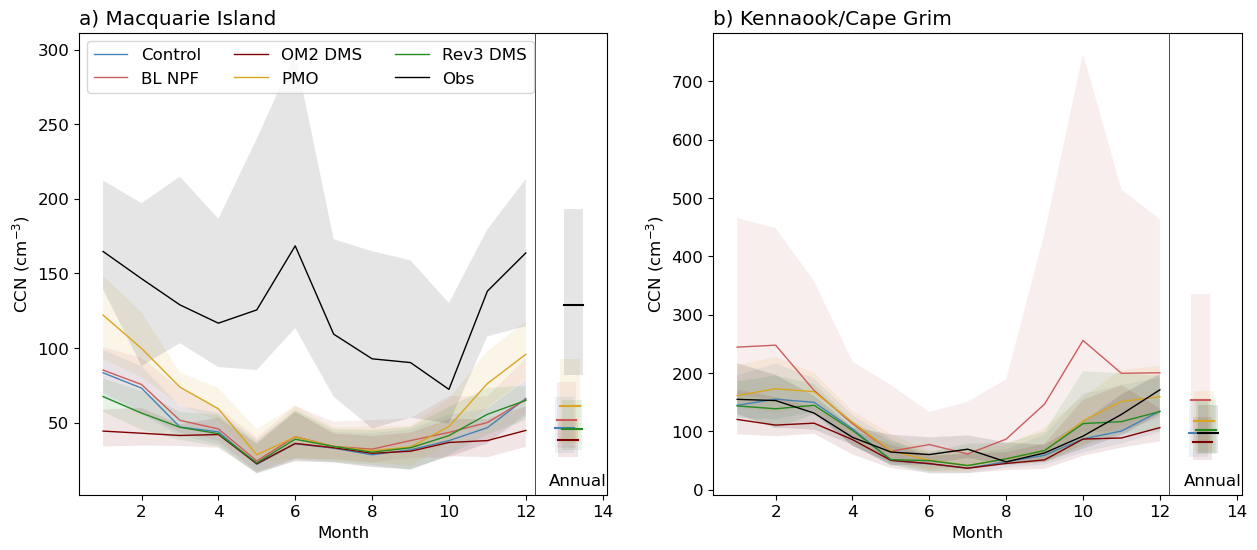

In [17]:
ax = plt.subplot(121,)
ax.figure.set_size_inches(15, 6)
data = combine_model_obs('Macquarie Island','CCN50',sim='all')
plot_station_monthly(data,'CCN50')
plt.title('a) Macquarie Island',loc='left');
plt.legend(ncols=3,loc='upper left')

#*********************************************************************************************************************

ax = plt.subplot(122,)
data = combine_model_obs('Kennaook-Cape Grim','CCN50',sim='all')
plot_station_monthly(data,'CCN50')
plt.title('b) Kennaook/Cape Grim',loc='left');


- Ok so clearly something wrong with KCG CCN, so will ignore for now. 

- FOR MI - a big part of ruhis paper was about this 'double peak' in the season - see the winter time peak there.. Interesting that the model does capture that a little bit, but not really enough. 
- Turning on PMO for MI helps accorss all seasons pretty much, but mostly in summer indicating that these bigger sea spray derived marine organics are important for this region. Likely more improvement in summer due to greater biological activity. (based on chlorophy - should check though). Is this peak driven by sea spray? Need to check what Ruhi's speculations were. Interesting that REV3 doesnt really help here, should check how it differs to Lana in this region. 


### Some stats

In [18]:
data = combine_model_obs('Macquarie Island','CCN50',sim='all')
data = data.to_xarray()
diffabs = data[run[:-1]] - data['Obs']
diffrel = 100*(data[run[:-1]]- data['Obs'])/data['Obs']
diffabs = diffabs.groupby('time.season').median()
diffrel = diffrel.groupby('time.season').median()

print('absolute diff Macquarie Island')
print(diffabs)
print(' ')
print('relative diff  Macquarie Island')
print(diffrel)

absolute diff Macquarie Island
<xarray.Dataset>
Dimensions:   (season: 4)
Coordinates:
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    Control   (season) float64 -79.15 -81.36 -75.34 -70.47
    BL NPF    (season) float64 -75.41 -77.75 -73.67 -61.71
    OM2 DMS   (season) float64 -112.3 -81.38 -83.34 -72.72
    PMO       (season) float64 -50.5 -78.82 -64.42 -47.72
    Rev3 DMS  (season) float64 -89.79 -78.99 -78.66 -64.46
 
relative diff  Macquarie Island
<xarray.Dataset>
Dimensions:   (season: 4)
Coordinates:
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    Control   (season) float64 -51.97 -70.87 -65.62 -64.16
    BL NPF    (season) float64 -50.3 -66.62 -63.74 -59.74
    OM2 DMS   (season) float64 -69.49 -71.32 -70.46 -68.0
    PMO       (season) float64 -31.83 -68.41 -54.86 -48.14
    Rev3 DMS  (season) float64 -57.43 -70.04 -67.24 -59.29


In [19]:
data = combine_model_obs('Kennaook-Cape Grim','CCN50',sim='all')
data = data.to_xarray()
diffabs = data[run[:-1]] - data['Obs']
diffrel = 100*(data[run[:-1]]- data['Obs'])/data['Obs']
diffabs = diffabs.groupby('time.season').median()
diffrel = diffrel.groupby('time.season').median()

print('absolute diff Kennaook-Cape Grim')
print(diffabs)
print(' ')
print('relative diff  Kennaook-Cape Grim')
print(diffrel)

absolute diff Kennaook-Cape Grim
<xarray.Dataset>
Dimensions:   (season: 4)
Coordinates:
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    Control   (season) float64 -8.53 -18.32 7.298 4.67
    BL NPF    (season) float64 77.89 28.35 35.79 84.82
    OM2 DMS   (season) float64 -40.41 -18.5 -5.023 -5.713
    PMO       (season) float64 5.972 -11.64 18.98 20.04
    Rev3 DMS  (season) float64 -11.09 -8.72 5.632 18.16
 
relative diff  Kennaook-Cape Grim
<xarray.Dataset>
Dimensions:   (season: 4)
Coordinates:
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    Control   (season) float64 -5.851 -24.27 10.63 5.843
    BL NPF    (season) float64 54.37 39.58 44.24 104.3
    OM2 DMS   (season) float64 -25.94 -27.49 -7.206 -9.18
    PMO       (season) float64 3.749 -15.49 22.08 29.56
    Rev3 DMS  (season) float64 -6.938 -12.25 9.5 20.85


# Plot CCN/CN activation ratio 

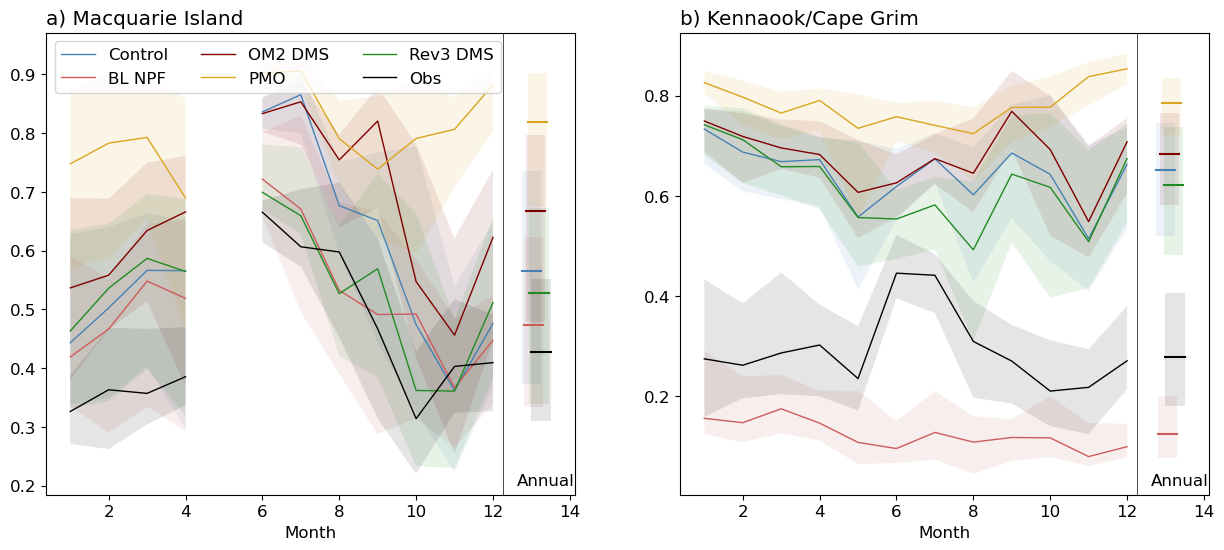

In [20]:
ax = plt.subplot(121,)
ax.figure.set_size_inches(15, 6)
dataN10 = combine_model_obs('Macquarie Island','N10',sim='all')
dataCCN = combine_model_obs('Macquarie Island','CCN50',sim='all')
data = dataCCN/dataN10
plot_station_monthly(data,'CCN/N10')
plt.title('a) Macquarie Island',loc='left');
plt.legend(ncols=3,loc='upper left')


#*********************************************************************************************************************

ax = plt.subplot(122,)
dataN10 = combine_model_obs('Kennaook-Cape Grim','N10',sim='all')
dataCCN = combine_model_obs('Kennaook-Cape Grim','CCN50',sim='all')
data = dataCCN/dataN10
plot_station_monthly(data,'CCN/N10')
plt.title('b) Kennaook/Cape Grim',loc='left');



Note that we need to still ignore KCG until we hear from Ruhi

- For MI, there are no coincident observaitons in May, hence the gap.
- NPF and Rev3 seem to get the closest ratio, better than the cotnrol, and are 'generally' in the bounds of variability for the second half of the year. Not so much for the first half where everything is pretty bad.
- Interesting that the PMO run has the worst ratio. It improved CCN, likely by contributing larger particles that could aleady act as CCN, but this maybe tells us that we actaully need more smaller particles to grow? Not sure - need to have a think about that.. 

# Plot voyage data by season and latitude

In [21]:
def get_counts(fc): 
    count = np.zeros(4)
    seasons = ['DJF','MAM','JJA','SON']
    for s in fc.Control.season.values:
        i = seasons.index(s)
        count[i] = fc.Control.loc[s]
        #print(fc.Control.loc[s].values)
    count = count.astype(int)
    return count

In [22]:
def plot_by_sea_lat(f,obsname,legend='no'):

    fm = f.groupby('time.season').median(dim=['time','Voyage'])
    fc = f.groupby('time.season').count(dim=['time','Voyage'])
    counts = get_counts(fc)
    f25 = f.groupby('time.season').quantile(0.25,dim=['time','Voyage'])
    f75 = f.groupby('time.season').quantile(0.75,dim=['time','Voyage'])
    for m,sim in enumerate(run):
        for s,sea in enumerate(['DJF','MAM','JJA','SON']):
            if sea in fm.season:
                if fm[sim].loc[sea].notnull():
                    if legend=='yes' and s == 0 : 
                        plt.plot([0.65+(m*0.05)+s,1.15+(m*0.05)+s],[fm[sim].loc[sea],fm[sim].loc[sea]],color=cols[m],label=sim)
                        plt.legend(ncol=2,loc='upper center')
                    else: 
                        plt.plot([0.65+(m*0.05)+s,1.15+(m*0.05)+s],[fm[sim].loc[sea],fm[sim].loc[sea]],color=cols[m])
                    ax.fill_between([0.65+(m*0.05)+s,1.15+(m*0.05)+s], f25[sim].loc[sea], 
                                    f75[sim].loc[sea], facecolor=cols[m],alpha=0.1)
    ax.set_xticklabels(['DJF ({})'.format(counts[0]),'MAM ({})'.format(counts[1]),
                        'JJA ({})'.format(counts[2]),'SON ({})'.format(counts[3])]);
    plt.xticks([1,2,3,4]);

# CN10

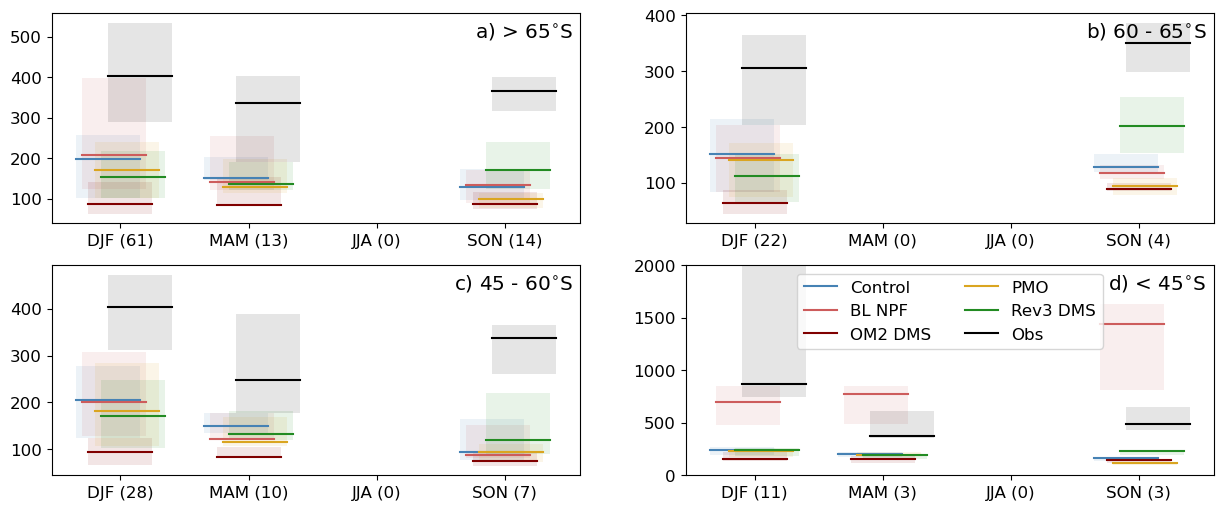

In [23]:
# CN10 
for v,vn in enumerate(obs_names[:-4]):
    f1 = combine_model_obs(vn,'N10',sim='all')
    f1 = f1.to_xarray()
    f1 = f1.assign_coords({'Voyage':vn})
    f1 = f1.expand_dims('Voyage')
    if v == 0: 
        f_all = f1
    else: 
        f_all = xr.concat([f_all,f1],dim='Voyage')


ax = plt.subplot(221,)
ax.figure.set_size_inches(15, 6)

f = f_all.where(f_all.lat>-65)
plot_by_sea_lat(f,'cn10_avg')
plt.title('a) > 65$^{\circ}$S  ',y=0.85,loc='right');


ax = plt.subplot(222,)
f = f_all.where((f_all.lat<-60) & (f_all.lat>-65))
plot_by_sea_lat(f,'cn10_avg')
plt.title('b) 60 - 65$^{\circ}$S  ',y=0.85,loc='right');

ax = plt.subplot(223,)
f = f_all.where((f_all.lat<-45) & (f_all.lat>-60))
plot_by_sea_lat(f,'cn10_avg')
plt.title('c) 45 - 60$^{\circ}$S  ',y=0.85,loc='right');

ax = plt.subplot(224,)
f = f_all.where((f_all.lat>-45))
plot_by_sea_lat(f,'cn10_avg',legend='yes')
plt.ylim(0,2000)
plt.title('d) < 45$^{\circ}$S  ',y=0.85,loc='right');

plt.subplots_adjust()

Line shows the median, the shading shows the 25th-75th percentils for each season, by latitudinal bins 

For CN10, no one simulation seems to improve the model accross the board. 
- in spring, the new DMS clim (Rev3) seems to do better in all latitudes, but not so much in other months.. 
- in the northern most lats, the BL NPF seems to improve the model the most in DJF, but in the other seasons over does it.. the big increase due to NPF is likely due to secondary organics from terrestrial sources.
- NPF is slightly increased in high lats, in summer, with a larger spread (eg. 25-75th percentiles) indicating the possible influence of biogenics in this region. 
- ACCESS OM2 DMS clim dramatically reduces CN10 - likely because it only represents one bulk phytoplankton species, which is not really ok.
- interesting that PMO generally decreases CN, likely due to it being an avalaible surface for condensational growth, therefore reducing small size aerosol (eg. sulfates)

## Some stats for seasonal/lat analysis of CN10 

### > 65S

In [24]:
f = f_all.where((f_all.lat<-65))
fm = f.groupby('time.season').median(dim=['time','Voyage'])
print('Absolute diffs')
(fm[run] - fm['Obs']).to_pandas()

Absolute diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-219.102791,-225.075039,-310.952053,-234.983723,-253.604673,0.0
MAM,NaN,NaN,NaN,NaN,NaN,NaN
SON,-169.155798,-182.020819,-226.239518,-224.193982,-132.029466,0.0


In [25]:
print('Relative diffs')
(100*(fm[run] - fm['Obs'])/fm['Obs']).to_pandas()

Relative diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-57.510927,-59.078545,-81.619868,-61.679414,-66.567111,0.0
MAM,NaN,NaN,NaN,NaN,NaN,NaN
SON,-45.556839,-49.021632,-60.930559,-60.379658,-35.558020,0.0


### 60-65S

In [26]:
f = f_all.where((f_all.lat<-60) & (f_all.lat>-65))
fm = f.groupby('time.season').median(dim=['time','Voyage'])
print('Absolute diffs')
(fm[run] - fm['Obs']).to_pandas()

Absolute diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-154.413052,-160.78705,-242.056409,-164.428303,-192.537870,0.0
MAM,NaN,NaN,NaN,NaN,NaN,NaN
SON,-221.139252,-232.15586,-260.955078,-255.779195,-149.064929,0.0


In [27]:
print('Relative diffs')
(100*(fm[run] - fm['Obs'])/fm['Obs']).to_pandas()

Relative diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-50.54861,-52.635200,-79.239513,-53.827200,-63.029139,0.0
MAM,NaN,NaN,NaN,NaN,NaN,NaN
SON,-63.16126,-66.307797,-74.533360,-73.055037,-42.575566,0.0


### 45-60S

In [28]:
f = f_all.where((f_all.lat<-45) & (f_all.lat>-60))
fm = f.groupby('time.season').median(dim=['time','Voyage'])
print('Absolute diffs')
(fm[run] - fm['Obs']).to_pandas()

Absolute diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-196.624776,-202.569428,-307.463761,-220.124264,-230.995779,0.0
MAM,-97.438087,-126.123617,-163.355466,-132.484174,-114.710537,0.0
SON,-243.113878,-249.457464,-263.284406,-243.716689,-217.408079,0.0


In [29]:
print('Relative diffs')
(100*(fm[run] - fm['Obs'])/fm['Obs']).to_pandas()

Relative diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-48.813935,-50.289750,-76.330747,-54.647902,-57.346857,0.0
MAM,-39.344662,-50.927633,-65.961534,-53.495971,-46.319130,0.0
SON,-71.993062,-73.871581,-77.966139,-72.171572,-64.380830,0.0


### < 45S

In [30]:
f = f_all.where((f_all.lat>-45))
fm = f.groupby('time.season').median(dim=['time','Voyage'])
print('Absolute diffs')
(fm[run] - fm['Obs']).to_pandas()

Absolute diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-632.489448,-178.217327,-715.632079,-644.593755,-637.464715,0.0
MAM,-165.443820,406.531555,-214.644542,-172.474098,-180.687380,0.0
SON,-322.739794,949.316247,-346.349740,-376.560988,-259.980278,0.0


In [31]:
print('Relative diffs')
(100*(fm[run] - fm['Obs'])/fm['Obs']).to_pandas()

Relative diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-72.363534,-20.389962,-81.875937,-73.748396,-72.932758,0.0
MAM,-44.794558,110.070001,-58.115845,-46.698034,-48.921812,0.0
SON,-65.865572,193.738916,-70.683951,-76.849541,-53.057448,0.0


# CCN

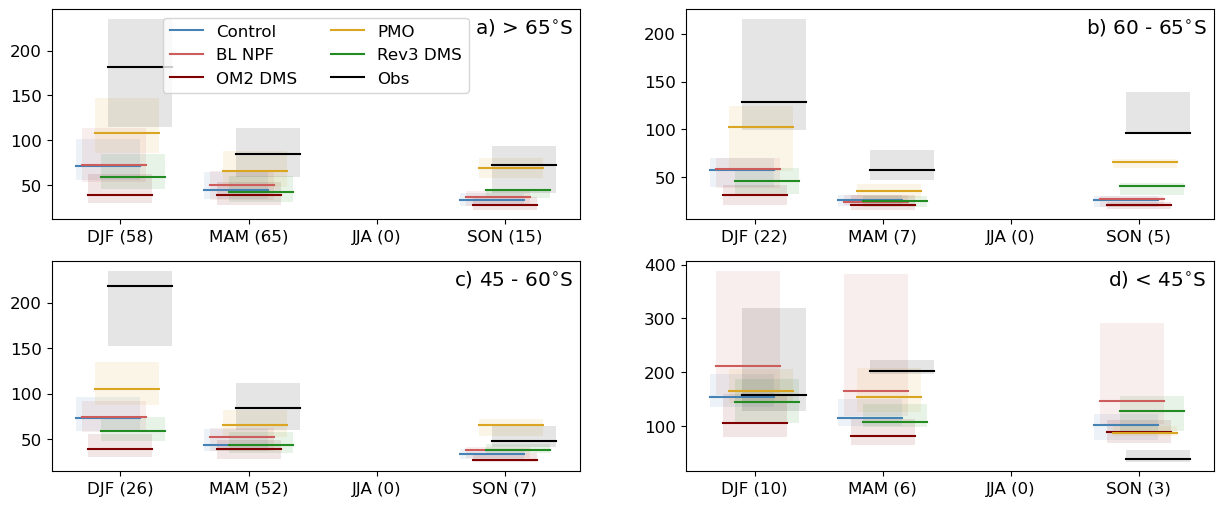

In [32]:
# CCN 
for v,vn in enumerate(obs_names[:-4]):
    f1 = combine_model_obs(vn,'CCN50',sim='all')
    f1 = f1.to_xarray()
    f1 = f1.assign_coords({'Voyage':vn})
    f1 = f1.expand_dims('Voyage')
    if v == 0: 
        f_all = f1
    else: 
        f_all = xr.concat([f_all,f1],dim='Voyage')


ax = plt.subplot(221,)
ax.figure.set_size_inches(15, 6)

f = f_all.where(f_all.lat>-65)
plot_by_sea_lat(f,'ccn_avg',legend='yes')
plt.title('a) > 65$^{\circ}$S  ',y=0.85,loc='right');


ax = plt.subplot(222,)
f = f_all.where((f_all.lat<-60) & (f_all.lat>-65))
plot_by_sea_lat(f,'ccn_avg')
plt.title('b) 60 - 65$^{\circ}$S  ',y=0.85,loc='right');

ax = plt.subplot(223,)
f = f_all.where((f_all.lat<-45) & (f_all.lat>-60))
plot_by_sea_lat(f,'ccn_avg')
plt.title('c) 45 - 60$^{\circ}$S  ',y=0.85,loc='right');

ax = plt.subplot(224,)
f = f_all.where((f_all.lat>-45))
plot_by_sea_lat(f,'ccn_avg')
plt.title('d) < 45$^{\circ}$S  ',y=0.85,loc='right');

plt.subplots_adjust()

Same deal as before: lines = median, boxes = 25-75th percentils. Note that this is for CCN50, as previous plots showed little difference between CCN50, CCN40 and CCN60. 

Overall, CCN is simulated much better than the CN10. But still pretty bad in a relative sense (see stats below)

- The PMO run generally improves the simulation of CCN accross the board, because it is directly introducing larger sized particles (it is based on sea spreay and chlorophyl)
- Turning on BL NPF also generally increases CCN concentrations... but probably not statistically significant (soz - havent run those stats...)
- Interestingly, in spring, in low lats is overestimated by the model... the low lats are generally the best simulated region, liekly due to biases in development. the higher lats are much worst (relativly speaking)
- Once again ACCESS-OM2 does a horrible job

## Some stats for seasonal/lat analysis of CCN

### >65S

In [33]:
f = f_all.where((f_all.lat<-65))
fm = f.groupby('time.season').median(dim=['time','Voyage'])
print('Absolute diffs')
(fm[run] - fm['Obs']).to_pandas()

Absolute diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-180.904458,-180.798641,-221.102623,-137.789542,-195.174532,0.0
MAM,-69.201880,-68.383559,-70.083625,-63.909398,-70.670348,0.0
SON,-63.667606,-61.717104,-75.476287,-36.937572,-39.517477,0.0


In [34]:
print('Relative diffs')
(100*(fm[run] - fm['Obs'])/fm['Obs']).to_pandas()

Relative diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-73.423953,-73.381005,-89.739241,-55.924840,-79.215769,0.0
MAM,-70.477165,-69.643764,-71.375160,-65.087152,-71.972696,0.0
SON,-58.727493,-56.928335,-69.619912,-34.071503,-36.451227,0.0


### 60-65S

In [35]:
f = f_all.where((f_all.lat<-60) & (f_all.lat>-65))
fm = f.groupby('time.season').median(dim=['time','Voyage'])
print('Absolute diffs')
(fm[run] - fm['Obs']).to_pandas()

Absolute diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-71.506556,-70.546437,-97.384867,-26.214879,-82.970103,0.0
MAM,-31.246431,-32.794325,-36.907944,-21.384631,-32.393555,0.0
SON,-70.711477,-69.552621,-75.079582,-30.396326,-55.280840,0.0


In [36]:
print('Relative diffs')
(100*(fm[run] - fm['Obs'])/fm['Obs']).to_pandas()

Relative diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-55.593592,-54.847137,-75.712981,-20.381059,-64.506058,0.0
MAM,-54.478582,-57.177356,-64.349507,-37.284398,-56.478608,0.0
SON,-73.345807,-72.143779,-77.876644,-31.528731,-57.340308,0.0


### 45-60S

In [37]:
f = f_all.where((f_all.lat<-45) & (f_all.lat>-60))
fm = f.groupby('time.season').median(dim=['time','Voyage'])
print('Absolute diffs')
(fm[run] - fm['Obs']).to_pandas()

Absolute diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-144.192517,-142.983281,-178.196789,-112.508557,-158.342781,0.0
MAM,-40.558836,-32.829216,-45.084878,-19.183368,-41.579343,0.0
SON,-14.662804,-10.738464,-20.846262,16.743629,-9.784218,0.0


In [38]:
print('Relative diffs')
(100*(fm[run] - fm['Obs'])/fm['Obs']).to_pandas()

Relative diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-66.169302,-65.614389,-81.773710,-51.629674,-72.662795,0.0
MAM,-47.783693,-38.677174,-53.115972,-22.600554,-48.985985,0.0
SON,-30.203409,-22.119795,-42.940502,34.489630,-20.154176,0.0


### <45S

In [39]:
f = f_all.where((f_all.lat>-45))
fm = f.groupby('time.season').median(dim=['time','Voyage'])
print('Absolute diffs')
(fm[run] - fm['Obs']).to_pandas()

Absolute diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-4.336555,53.735038,-51.557749,7.055714,-12.533220,0.0
MAM,-87.305734,-36.809428,-120.425491,-47.159331,-93.217801,0.0
SON,63.850893,106.662890,49.884006,47.907127,89.702356,0.0


In [40]:
print('Relative diffs')
(100*(fm[run] - fm['Obs'])/fm['Obs']).to_pandas()

Relative diffs


,Control,BL NPF,OM2 DMS,PMO,Rev3 DMS,Obs
season,,,,,,
DJF,-2.741372,33.968842,-32.592459,4.460300,-7.922930,0.0
MAM,-43.235482,-18.228738,-59.637023,-23.354209,-46.163251,0.0
SON,161.610620,269.970475,126.259552,121.255948,227.042299,0.0


# Conclusions
(so far)

- can probaly reccomend that PMO be turned on and the new DMS clim be used as well.
- These is a serious problem with how the model represents small sizedd aerosol. While these are not cloud/radiation relevant (too small) so likely do not have a large influence on broader climate, this is a problem that should be address, especaily as new chemical pathways (like MSA) are beginning to be included in the UKCA 